In [1]:
# import all packages
import pandas as pd 
import numpy as np 
import textwrap 

import seaborn as sns 
import matplotlib.pyplot as plt 

import shap 

from sklearn.preprocessing import StandardScaler 
from sklearn import linear_model 

from sklearn.model_selection import KFold, cross_validate, cross_val_predict, RepeatedKFold, cross_val_score, GridSearchCV 
from sklearn.metrics import r2_score, mean_absolute_error 

import statsmodels.api as sm

/Users/etiennechenevert/opt/anaconda3/envs/qwasd/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Since we are working with a small dataset, we will be training and testing our model many times through our cross validation scheme. Then we present the final model performances.

# Bayesian Ridge Regression Implementation

We decide to utilize a Bayesian Ridge, L2 regularization, regression in this tutorial. In my implementation of Bayesian Ridge Regression model, I explicitly conduct repeated cross validation by randomly splitting my dataset into K-folds and iterating this process 100 times through a loop. I do this in order to extract the learned parameters and predictions of each of the 500 models (5 fold splits repeated 100 times) and plot them in the subsequent graphs. 

However, I need to first make a function that un-standardizes the weight coefficients so they interpretable in the usual way of "a 1 unit increase in X results in a value-of-weight-coefficient increase in y."

In [17]:
def unscaled_weights_from_Xstandardized(X, bayesianReg: linear_model):
    """
    This code only works for Bayesian Ridge Regression. We rescale the weights using a rearrangement of the 
    scaled linear regression equation.
    X: dataframe
    bayesianReg: linear model from scikit learn
    Helpful source:
    https://stats.stackexchange.com/questions/74622/converting-standardized-betas-back-to-original-variables
    """
    a = bayesianReg.coef_
    i = bayesianReg.intercept_
    # Me tryna do my own thing
    coefs_new = []
    for x in range(len(X.columns)):
        # print(X.columns.values[x])
        col = X.columns.values[x]
        coefs_new.append((a[x] / (np.asarray(X.std()[col]))))
    intercept = i - np.sum(np.multiply(np.asarray(coefs_new), np.asarray(X.mean()/X.std())))  # hadamard product

    return coefs_new, intercept

Now, because linear regression models are prone to overfitting the data we need to select only the essential variables for predicting our outcome, vertical accretion rate. Overfitting the data occurs when our model ends up finding a function that approximates our training data too much, so that when given new data it performs poorly.

<a id='_featureselection'></a>
The process of finding only the necessary variables for our model is called ***feature selection*** and there are two ways to proceed through it. Option one is to simply apply our domain knowledge on the subject we want to approximate, sedimentation on marsh environments. In this methodology, we will consult our previous knowledge on how sedimentation occurs in these environments and include every variable we deem necessary to model accretion rates. However, this approach is not always feasible for highly complex relationships or for situations where we do not have sufficient domain knowledge on our outcome variable. Option two applies an unbiased, reproducible methodology based on some metric. A popular choice for this approach is to use an algorithm called *backward feature selection.* In the algorithm, we fit a multivariate linear regression to our outcome variable using all of our data, then compute the p-value for each variable. We then iteratively drop the variable with the highest p-value until every variables has a p-value below a given threshold, generally 0.05. 

We are going to use the backward elimination approach to feature selection because marsh vertical accretion rates can depend on many different environmental variables due these environments being at the confluence on land, rivers, and ocean. Therefore, we want to reduce the complexity of our linear regression for vertical accretion by only selecting statistically significant variables related to it. 

Below is our implementation of backward elimination.

In [18]:
def backward_elimination(data, target, num_feats=10, significance_threshold=0.05):
    """
    data: dataframe of predictors
    target: dataframe of target variable
    num_feats: maximum number of features to be included in the return list
    significance_threshold: threshold p-value that determines significance and elimination
    
    returns: list of significant variables
    
    Code is adapted from: 
    https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/#:~:text=1.-,Forward%20selection,with%20all%20other%20remaining%20features.
    """
    features = data.columns.tolist()
    target = list(target)
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_threshold) or (len(features) > num_feats):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break
    return features

# Obtain a list of the significant variables
bestfeatures = backward_elimination(data=data, target=target, num_feats=10, significance_threshold=0.05)
print(bestfeatures)

['Soil Porewater Salinity (ppt)', 'NDVI', 'TSS (mg/l)', 'Windspeed (m/s)', 'Tidal Amplitude (cm)', '90th Percentile Flood Depth (cm)']


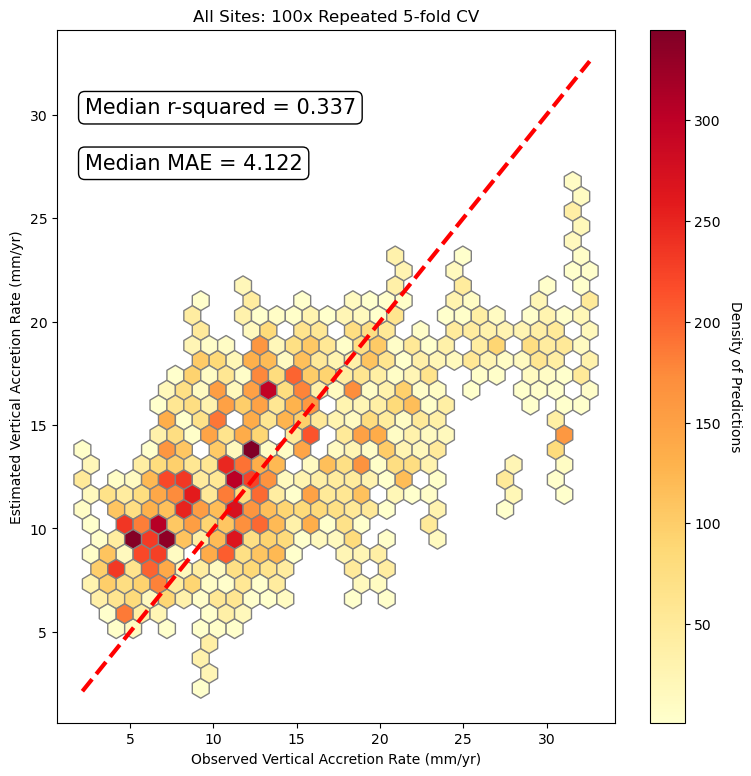

['Scaled Weights', 'Unscaled Weights', 'Scaled regularizors', 'Predictions']


In [19]:
# Plotting and parameter retrieval function for Ridge and BLR Ridge
def cv_results_and_plot(baymod, unscaled_predictor_matrix, predictor_matrix, target, color_scheme: dict):
    features = list(predictor_matrix.columns)
    # Error Containers
    predicted = []  # holds they predicted values of y
    y_ls = []  # holds the true values of y

    hold_weights = {}  # container that holds the learned weight vectors
    hold_unscaled_weights = {}  # container that holds the inverted learned weight vectors
    hold_regularizors = {}  # container that holds the learned regularization constant
    hold_predicted = {}

    # Performance Metric Containers: I allow use the median because I want to be more robust to outliers
    r2_total_medians = []  # holds the k-fold median r^2 value. Will be length of 100 due to 100 repeats
    mae_total_medians = [] # holds the k-fold median Mean Absolute Error (MAE) value. Will be length of 100 due to 100 repeats

    # parameter holders
    weight_vector_ls = []  # holds the learned parameters for each k-fold test
    regularizor_ls = []  # holds the learned L2 regularization term for each k-fold test
    unscaled_w_ls = [] # holds the inverted weights to their natural scales
    prediction_list = []

    for i in range(100):  # for 100 repeats
        try_cv = KFold(n_splits=5, shuffle=True)
        results_for_3fold = cross_validate(baymod, predictor_matrix, target.values.ravel(), cv=try_cv,
                                           scoring=('r2', 'neg_mean_absolute_error'),
                                           n_jobs=-1, return_estimator=True)
        # Scaled lists
        r2_ls = []
        mae_ls = []
        # Inversed lists
        r2_inv_ls = []
        mae_inv_ls = []
        # Certainty lists
        pred_list = []

        for train_index, test_index in try_cv.split(predictor_matrix):
            X_train, X_test = predictor_matrix.iloc[train_index], predictor_matrix.iloc[test_index]
            y_train, y_test = target.iloc[train_index], target.iloc[test_index]
            # Fit the model
            baymod.fit(X_train, y_train.values.ravel())
            # collect unscaled parameters
            unscaled_weights, intercept = unscaled_weights_from_Xstandardized(unscaled_predictor_matrix[features],
                                                                              baymod)
            unscaled_w_ls.append(unscaled_weights)

            # Collect scaled parameters
            weights = baymod.coef_
            weight_vector_ls.append(abs(weights))  # Take the absolute values of weights for relative feature importance
            regularizor = baymod.lambda_ / baymod.alpha_
            regularizor_ls.append(regularizor)
            design_m = np.asarray(X_train)
            eigs = np.linalg.eigh(baymod.lambda_ * (design_m.T @ design_m))

            # Make our predictions for y
            ypred = baymod.predict(X_test)
            pred_list += list(ypred)

            # Metrics for scaled y: particularly for MAE
            r2 = r2_score(y_test, ypred)
            r2_ls.append(r2)
            mae = mean_absolute_error(y_test, ypred)
            mae_ls.append(mae)
            # Metrics for inversed y: particularly for MAE
            r2_inv = r2_score(y_test, ypred)
            r2_inv_ls.append(r2_inv)
            mae_inv = mean_absolute_error(y_test, ypred)
            mae_inv_ls.append(mae_inv)

        # Average certainty in predictions
        prediction_list.append(pred_list)

        # Average predictions over the Kfold first: scaled
        r2_median = np.median(r2_ls)
        r2_total_medians.append(r2_median)
        mae_median = np.median(mae_ls)
        mae_total_medians.append(mae_median)

        predicted = predicted + list(cross_val_predict(baymod, predictor_matrix, target.values.ravel(), cv=try_cv))
        y_ls += list(target.values.ravel())

    # Add each of the model parameters to a dictionary
    weight_df = pd.DataFrame(weight_vector_ls, columns=features)
    unscaled_weight_df = pd.DataFrame(unscaled_w_ls, columns=features)
    
    # Now calculate the mean of th kfold means for each repeat: scaled accretion
    r2_final_median = np.median(r2_total_medians)
    mae_final_median = np.median(mae_total_medians)
    
    # Below code is for the figure
    fig, ax = plt.subplots(figsize=(9, 9))
    hb = ax.hexbin(x=y_ls,
                   y=predicted,
                   gridsize=30, edgecolors='grey',
                   cmap=color_scheme['cmap'], mincnt=1)
    ax.set_facecolor('white')
    ax.set_xlabel("Observed Vertical Accretion Rate (mm/yr)")
    ax.set_ylabel("Estimated Vertical Accretion Rate (mm/yr)")
    ax.set_title("All Sites: 100x Repeated 5-fold CV")
    cb = fig.colorbar(hb, ax=ax)
    cb.ax.get_yaxis().labelpad = 15
    cb.set_label('Density of Predictions', rotation=270)
    ax.plot([target.min(), target.max()], [target.min(), target.max()],
        color_scheme['line'], lw=3)

    ax.annotate("Median r-squared = {:.3f}".format(r2_final_median), xy=(20, 450), xycoords='axes points',
                bbox=dict(boxstyle='round', fc='w'),
                size=15, ha='left', va='top')
    ax.annotate("Median MAE = {:.3f}".format(mae_final_median), xy=(20, 410), xycoords='axes points',
                bbox=dict(boxstyle='round', fc='w'),
                size=15, ha='left', va='top')
    plt.show()
    
    return {
        "Scaled Weights": weight_df, 
        "Unscaled Weights": unscaled_weight_df, 
        "Scaled regularizors": regularizor_ls, 
        "Predictions": prediction_list, 
    }


results_dict = cv_results_and_plot(br, phi, data[bestfeatures], target, {'cmap': 'YlOrRd', 'line': 'r--'})
# lets look at the keys of the returned results dictionary for future reference
print(list(results_dict.keys()))

Using the significant variables, our implemented Bayesian Linear Regression was able to capture ~0.33% of the variability associated with accretion. The scatter plot above is a one-to-one plot of the estimated versus observed accretion values. We can see how most of our error is associated with predicting the vertical accretion rates greater than 25 mm/yr. This can be due to a plethora of reasons, however, the most parsimonious seems to be because more stochastic processes that are not captured in our model drive accretion rates of that magnitude. 

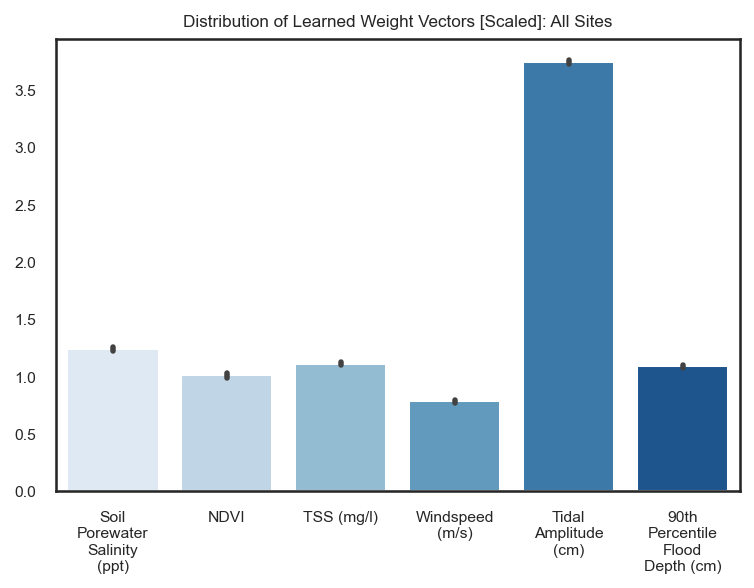

Soil Porewater Salinity (ppt)       1.240714
NDVI                                1.010291
TSS (mg/l)                          1.111033
Windspeed (m/s)                     0.784466
Tidal Amplitude (cm)                3.744493
90th Percentile Flood Depth (cm)    1.088783
dtype: float64

In [20]:
# Write a function for the visualization of plots: will wrap the labels of plots
def wrap_labels(ax, width, break_long_words=False):
    """ This function is only for the visualization of plots
    
    ax: plot axis object 
    width: width of textwrap
    break_long_words: boolean as to break long words in wrapping or not
    
    directly from: https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
    """
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

    
# Lets plot the feature importances from the collected scaled weights
sns.set_theme(style='white', rc={'figure.dpi': 147}, font_scale=0.7)
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Distribution of Learned Weight Vectors [Scaled]: All Sites')
sns.barplot(data=results_dict['Scaled Weights'], palette="Blues")
wrap_labels(ax, 10)
plt.show()

results_dict['Scaled Weights'].mean()

The bar chart above indicates the relative feature importances of the identified variables. We are able to achieve this feature importance through the absolute value of the weight coefficients for each input variable. This works because, prior to the fitting of the model, we scaled our weight coefficients to all lie within the the same range. Thus, we can interpret the magnitude of the weight coefficient learned from the scaled input features to be the relative importance of that feature.

Of the identified salient variables from the dataset related to vertical accretion, we see that tidal amplitude is the most important variable contributing to accretion in our linear model, while suspended sediment concentration is the least important variable contributing to accretion in the model. However, be sure to note that suspended sediment is still a significant variable defined by the backward elimination algorithm.

Something to consider here is the multicollinearity between the variables that is inherent to these environments. We must acknowledge that this potential bias may affect any future interpretations of the model. Additionally, the feature importances of each variable will vary depending on which type of model they are fit to. 

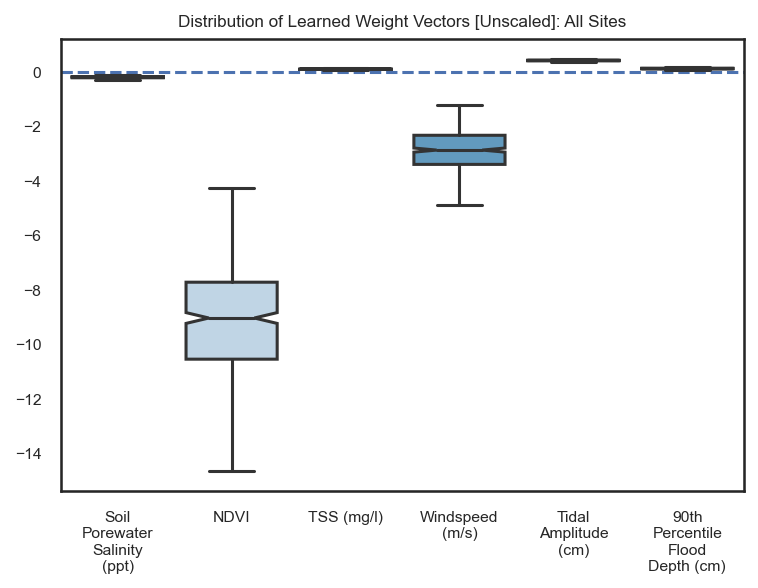

Soil Porewater Salinity (ppt)      -0.205421
NDVI                               -9.117248
TSS (mg/l)                          0.085246
Windspeed (m/s)                    -2.882275
Tidal Amplitude (cm)                0.406819
90th Percentile Flood Depth (cm)    0.110440
dtype: float64

In [21]:
# Plot the rescaled weight coefficients
sns.set_theme(style='white', rc={'figure.dpi': 147}, font_scale=0.7)
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Distribution of Learned Weight Vectors [Unscaled]: All Sites')
ax.axhline(0, ls='--')
boxplot = sns.boxplot(data=results_dict['Unscaled Weights'], notch=True, showfliers=False, palette="Blues")
wrap_labels(ax, 10)
plt.show()

results_dict["Unscaled Weights"].mean()

The above plot is now the rescaled weight coefficients. They are represented through a boxplot because, since we run a 5-fold 100x repeated cross validation scheme, we train 500 models with slightly different learned weights because of varying splits of the data. Therefore, it is important to show the full range of the learned weights. We can interpret these as one would usually for any ordinary least squares regression such as "a one centimeter increase in tidal amplitude results in a ~0.41 mm/yr increase in the vertical accretion rate at a CRMS station."

These weight coefficients give us both the magnitude and direction of change. An increase in soil porewater salinity, NDVI, 90th percentile flood depth, and 10th percentile flood depth all negatively influence our models estimated accretion rate. While TSS, tidal amplitude, average percent time flooded, and flood depth all positively influence estimated deposition rates.

# Training and Testing the Gaussian Process Regression Model

In [27]:
# Load packages relevant for the gaussian process regression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, DotProduct, WhiteKernel, Matern, Sum

# GP model 
gp = GaussianProcessRegressor(kernel=(DotProduct()**2) + WhiteKernel(),
                              n_restarts_optimizer=10, alpha=1, normalize_y=False, random_state=123)

rcv = RepeatedKFold(n_splits=5, n_repeats=100, random_state=123)
scores = cross_validate(gp, shap_df, target, cv=rcv, 
                        scoring=('r2', 'neg_mean_absolute_error'), return_train_score=True)
print("Median GP R^2 score", np.median(scores['test_r2']))
print("Median GP MAE score", abs(np.median(scores['test_neg_mean_absolute_error'])))

Median GP R^2 score 0.43936522408587403
Median GP MAE score 3.635438434459999


Great! We increase out model performance by around 10%. But, we do not know anything about how the model is able to achieve its better accuracy yet.